In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
dataset=pd.read_csv('data.csv')
dataset.head()


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
# Making target value numeric
dataset.dropna(subset=['target'], inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset['target'] = dataset['target'].astype(str)
dataset['target'] = dataset['target'].str.strip()
dataset['target'] = dataset['target'].str.replace('/mo', '', regex=False)
dataset['target'] = dataset['target'].str.replace('$', '', regex=False)
dataset['target'] = dataset['target'].str.replace(',', '', regex=False)
dataset['target'] = dataset['target'].str.replace('+', '', regex=False)
dataset['target'] = dataset['target'].str.replace(' ', '', regex=False)


def mean_target(data):
    # Apply only to rows where '-' is in the string
    mask = data['target'].astype(str).str.contains('-')

    # Split and compute mean only for those rows
    data.loc[mask, 'target'] = data.loc[mask, 'target'].str.split('-').apply(
        lambda x: np.mean([int(i.strip()) for i in x]) if isinstance(x, list) else x
    )

    return data  # return the modified DataFrame

dataset = mean_target(dataset)
dataset['target'] = dataset['target'].astype(int)
dataset['target'] = dataset['target'].replace(0, np.nan, regex=False)
dataset.dropna(subset=['target'], inplace=True)
dataset.reset_index(drop=True, inplace=True)


# Removing column private pool after completing with useful values the duplicate column PrivatePool
dataset['PrivatePool'] = dataset.apply(
    lambda row: 'Yes' if row['private pool'] == 'Yes' or str(row['PrivatePool']).strip().lower() == 'yes' else 'No',
    axis=1)
dataset['PrivatePool']=dataset['PrivatePool'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset.drop(['private pool'], axis=1, inplace=True)


# Transformation of status column
dataset['status'] = dataset['status'].str.replace(r'^Coming soon.*', 'Coming soon', regex=True)
dataset['status'] = dataset['status'].str.replace(r'^New.*', 'New', regex=True)

dataset['status'] = np.where(dataset['status'].str.contains('for rent', case=False, na=False),
    'Rent',
    dataset['status']
)
dataset['status'] = np.where(
    dataset['status'].str.contains(r'\bActive\b', case=False, na=False),
    'Active',
    dataset['status']
)

dataset['status'] = np.where(
    dataset['status'].str.contains(r'\bPending\b', case=False, na=False),
    'Pending',
    dataset['status']
)
dataset['status'] = np.where(
    dataset['status'].str.contains(r'\bRe[\s\-]?activated\b', case=False, na=False),
    'Active',
    dataset['status']
)

dataset['status'] = np.where(
    dataset['status'].str.contains(r'^Under Contract', case=False, na=False),
    'Under Contract',
    dataset['status']
)

dataset['status'] = np.where(
    dataset['status'].str.contains(r'auction', case=False, na=False),
    'Auction',
    dataset['status']
)
dataset['status'] = np.where(
    dataset['status'].str.contains(r'\bcontingent|contingency\b', case=False, na=False),
    'Contingent',
    dataset['status']
)
dataset['status'] = np.where(
    dataset['status'].str.contains(r'backup', case=False, na=False),
    'Backup',
    dataset['status']
)
dataset['status'] = dataset['status'].apply(lambda x: 'Pending' if x == 'P' or x=='Contract P' else x)
dataset['status'] = dataset['status'].apply(lambda x: 'Coming soon' if x == 'C' else x)
dataset['status'] = dataset['status'].apply(lambda x: 'Under Contract' if x == 'C Continue Show' else x)
dataset['status'] = dataset['status'].str.replace('for sale', 'For sale', regex=True)
dataset['status'] = dataset['status'].str.replace('foreclosure', 'Foreclosure', regex=True)
dataset['status'] = dataset['status'].replace({'Ct': 'Contingent'})
dataset['status'] = dataset['status'].replace({'U Under Contract': 'Under Contract'})
dataset['status'] = dataset['status'].replace({'For sale': 'For Sale'})
dataset['status'] = dataset['status'].replace({'Back on Market': 'Back On Market'})
dataset['status'] = dataset['status'].replace({'Ps': 'Pending'})
dataset['status'] = dataset['status'].replace({'Pf': 'Pre-Foreclosure'})
dataset['status'] = dataset['status'].replace({'Pi': 'Pending'})
dataset['status'] = dataset['status'].replace({'Uc Continue To Show': 'Under Contract'})
dataset['status'] = dataset['status'].replace({'Contract': 'Under Contract'})
dataset['status'] = dataset['status'].replace({'Conditional Contract': 'Contingent'})
dataset['status'] = dataset['status'].fillna('Other')

# Transformation of city, zipcode and state columns
dataset['city'] = dataset['city'].fillna('City')
dataset.drop(columns=['street'], inplace=True)
dataset['address']=dataset['city']+' '+dataset['zipcode']
dataset.drop(columns=['zipcode', 'city'], inplace=True)

# Bathrooms
dataset['baths'] = dataset['baths'].str.replace(r'Baths|Bathrooms', '', regex=True).str.strip()
dataset['baths'] = dataset['baths'].str.extract(r'^(\d+)')
dataset['baths'] = pd.to_numeric(dataset['baths'], errors='coerce')

#
import ast

def safe_parse_dict(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

# Convert string to dict
series = dataset['homeFacts'].apply(safe_parse_dict)


#

def extract_facts(d):
    if isinstance(d, dict) and 'atAGlanceFacts' in d:
        return {item.get('factLabel'): item.get('factValue') for item in d.get('atAGlanceFacts', [])}
    return {}

facts_series = series.apply(extract_facts)
facts_df = pd.DataFrame(facts_series.tolist())

# Removing Price/sqft due to data leakage risk
dataset = pd.concat([dataset, facts_df], axis=1)
dataset.drop(columns=['homeFacts'], inplace=True)
dataset.drop('lotsize', axis=1, inplace=True)
dataset.drop('Price/sqft', axis=1, inplace=True) #Data Leakage risk
dataset.drop(columns=['Heating', 'Cooling', 'Parking', 'propertyType'], inplace=True)

# Fireplaces
fire_mapping={'yes':'Yes', '1':'Yes', '2':'Yes', '3':'Yes', '5':'Yes', 'Not Applicable':'No', '0':'No', None: 'No'}
dataset['fireplace']=dataset['fireplace'].replace(fire_mapping)
dataset['fireplace']=dataset['fireplace'].apply(lambda x: 'Yes' if x!='No' else 'No')
dataset['fireplace']=dataset['fireplace'].map({'Yes':1, 'No':0})
# Removing of MlsID and mls-id
dataset.drop(columns=['MlsId', 'mls-id'], inplace=True)

In [5]:
import re

def normalize_grade_range(s):
    if not isinstance(s, str):
        return ""
    s = s.replace('–', '-').replace('to', '-').replace('–', '-')
    s = s.replace('Preschool', 'PK').replace('Pk', 'PK').replace('NA', '').replace('N/A', '')
    s = s.upper()
    return s


def expand_grade_range(g):
    g = normalize_grade_range(g)
    if not g:
        return set()

    grade_list = []
    parts = g.split(',')

    for part in parts:
        part = part.strip()
        if '-' in part:
            start, end = part.split('-')
            start = start.strip()
            end = end.strip()

            def grade_to_num(x):
                if x == 'PK':
                    return -1
                if x == 'K':
                    return 0
                if x.isdigit():
                    return int(x)
                return None

            s_num = grade_to_num(start)
            e_num = grade_to_num(end)

            if s_num is not None and e_num is not None:
                grade_list.extend(range(s_num, e_num + 1))
        else:
            if part == 'PK':
                grade_list.append(-1)
            elif part == 'K':
                grade_list.append(0)
            elif part.isdigit():
                grade_list.append(int(part))

    return set(grade_list)


def classify_levels(grade_set):
    levels = {
        'has_preschool': any(g < 0 for g in grade_set),
        'has_elementary': any(0 <= g <= 5 for g in grade_set),
        'has_middle': any(6 <= g <= 8 for g in grade_set),
        'has_high': any(9 <= g <= 12 for g in grade_set)
    }
    return pd.Series(levels)

#
# Step: From raw 'schools' column, extract all grade strings
def extract_all_grades(school_entry):
    try:
        return eval(school_entry)[0]['data']['Grades']
    except:
        return []


# Create column with all parsed numeric grades
# Step 1: Extract numeric grades from the raw 'schools' column
dataset['grade_set'] = dataset['schools'].apply(
    lambda x: set().union(*[expand_grade_range(g) for g in extract_all_grades(x)])
)

# Step 2: Classify into school level booleans
dataset[['has_preschool', 'has_elementary', 'has_middle', 'has_high']] = dataset['grade_set'].apply(classify_levels)

# num_schools — Count of Nearby Schools
def count_schools(s):
    try:
        return len(eval(s)[0]['name'])
    except:
        return 0

dataset['num_schools'] = dataset['schools'].apply(count_schools)

# avg_rating — Average Rating (Ignoring 'NR')
import numpy as np

def clean_rating(val):
    if val in ['NR', 'NA', 'None/10', '', None]:
        return None
    if isinstance(val, str):
        if '/10' in val:
            val = val.split('/')[0]
        if val.isdigit():
            return float(val)
    return None

def compute_avg_max_rating(school_entry):
    try:
        ratings = eval(school_entry)[0]['rating']
        clean_ratings = [clean_rating(r) for r in ratings]
        clean_ratings = [r for r in clean_ratings if r is not None]
        if clean_ratings:
            avg_rating = round(np.mean(clean_ratings), 2)
            max_rating = max(clean_ratings)
        else:
            avg_rating = None
            max_rating = None
        return avg_rating, max_rating
    except:
        return None, None

# Apply to each row
dataset[['avg_rating', 'max_rating']] = dataset['schools'].dropna().apply(
    lambda x: pd.Series(compute_avg_max_rating(x))
)

dataset.drop(columns=['schools', 'grade_set'], inplace=True)
dataset['avg_rating'].fillna(dataset['avg_rating'].mean(), inplace=True)
dataset['max_rating'].fillna(dataset['max_rating'].mean(), inplace=True)

# Beds
mask_beds = dataset['beds'].str.lower().str.contains('acre|sqf|bath', na=False)
dataset.loc[mask_beds, 'beds'] = np.nan
dataset['beds'] = dataset['beds'].str.replace(r'(beds?|bd)', '', case=False, regex=True).str.strip()
dataset['beds'] = dataset['beds'].replace('1-2', '1')
dataset['beds'] = dataset['beds'].replace('--', np.nan)
dataset['beds'] = dataset['beds'].replace('', np.nan)
dataset['beds']=dataset['beds'].replace('3 or More rooms, Dining Room, Living Room, Range/Oven, Refrigerator', '3')
dataset['beds'] = dataset['beds'].apply(
    lambda x: np.nan if isinstance(x, str) and len(x) >= 15 else x
)
dataset['beds'] = pd.to_numeric(dataset['beds'], errors='coerce')


In [6]:
mask = ((dataset['sqft'] == '0') | (dataset['sqft'].isna())) & \
       (dataset['baths'].isna()) & \
       (dataset['beds'].isna())
dataset = dataset[~mask]

mask=dataset['beds'].isna()
print(dataset[mask][['beds', 'baths']])
# SQFT
dataset['sqft'] = dataset['sqft'].str.replace('Total interior livable area:', '', regex=False)
dataset['sqft'] = dataset['sqft'].str.replace('sqft', '', regex=False)
dataset['sqft'] = dataset['sqft'].str.replace(',', '', regex=False)
dataset['sqft'] = dataset['sqft'].replace('0', np.nan)
dataset['sqft'] = dataset['sqft'].replace('--', np.nan)
dataset['sqft'] = dataset['sqft'].str.strip()
import numpy as np

def parse_sqft(value):
    try:
        # Handle range values like '610-840'
        if '-' in str(value):
            parts = value.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        # Handle normal numeric values
        return float(value)
    except:
        return np.nan

dataset['sqft'] = dataset['sqft'].apply(parse_sqft)

dataset.dropna(subset=['sqft'], inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset['sqft'] = dataset['sqft'].astype(int)


#
dataset['beds'].fillna(dataset['baths'], inplace=True)
dataset['baths'].fillna(dataset['beds'], inplace=True)

# Beds and Baths
# Compute ratios (excluding NaNs)
beds_per_sqft = dataset['beds'].sum(skipna=True) / dataset['sqft'].sum(skipna=True)
baths_per_sqft = dataset['baths'].sum(skipna=True) / dataset['sqft'].sum(skipna=True)

# Fill missing 'beds' using sqft
dataset.loc[dataset['beds'].isna(), 'beds'] = (
    dataset.loc[dataset['beds'].isna(), 'sqft'] * beds_per_sqft
).round()

# Fill missing 'baths' using sqft
dataset.loc[dataset['baths'].isna(), 'baths'] = (
    dataset.loc[dataset['baths'].isna(), 'sqft'] * baths_per_sqft
).round()
# Stories
non_digit_stories = dataset[~dataset['stories'].astype(str).str.match(r'^\d+(\.\d+)?$')]
non_digit_values = non_digit_stories['stories'].dropna().unique().tolist()


        beds  baths
6        NaN    NaN
11       NaN    NaN
16       NaN    1.0
17       NaN    NaN
22       NaN    1.0
...      ...    ...
374666   NaN    NaN
374677   NaN    2.0
374678   NaN    1.0
374683   NaN    NaN
374696   NaN    NaN

[68857 rows x 2 columns]


In [7]:
import re


def map_stories_to_int(value):
    if pd.isna(value):
        return np.nan

    val = str(value).lower()

    # Exact numeric match (like '1.0', '2', etc.)
    match = re.match(r'^(\d+)', val)
    if match:
        return int(match.group(1))

    # Keyword mapping
    keywords = {
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5,
        'six': 6,
        'seven': 7,
        'eight': 8,
        'nine': 9,
        'ten': 10,
        'eleven': 11,
        'twelve': 12,
        '1.5': 2,     # Approximate 1.5 → 2
        '2.5': 3,     # Approximate 2.5 → 3
        '3+': 3,
        '3 - 5': 4,
        'split': 2,
        'tri': 3,
        'multi': 3,
        'fourplex': 2,
        'sixplex': 3,
        'duplex': 2,
        'triplex': 3,
    }

    for key, val_int in keywords.items():
        if key in val:
            return val_int

    return np.nan

dataset['stories'] = dataset['stories'].apply(map_stories_to_int)
dataset['stories'] = dataset['stories'].fillna(1)

#Year built
dataset['Year built'] = dataset['Year built'].apply(lambda x: np.nan if pd.notna(x) and len(str(x)) != 4 else x)
dataset['Year built'] = dataset['Year built'].replace([None, ''], np.nan)
dataset.drop('Remodeled year', axis=1, inplace=True)

dataset['Year built'] = pd.to_numeric(dataset['Year built'], errors='coerce')
dataset.loc[dataset['Year built'] < 1800, 'Year built'] = np.nan
dataset.loc[dataset['Year built'] > 2025, 'Year built'] = np.nan
dataset['Year built'].fillna(dataset['Year built'].mode()[0], inplace=True)

# Basic Statistical analysis & Visualization

C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\910428996.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\910428996.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\910428996.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


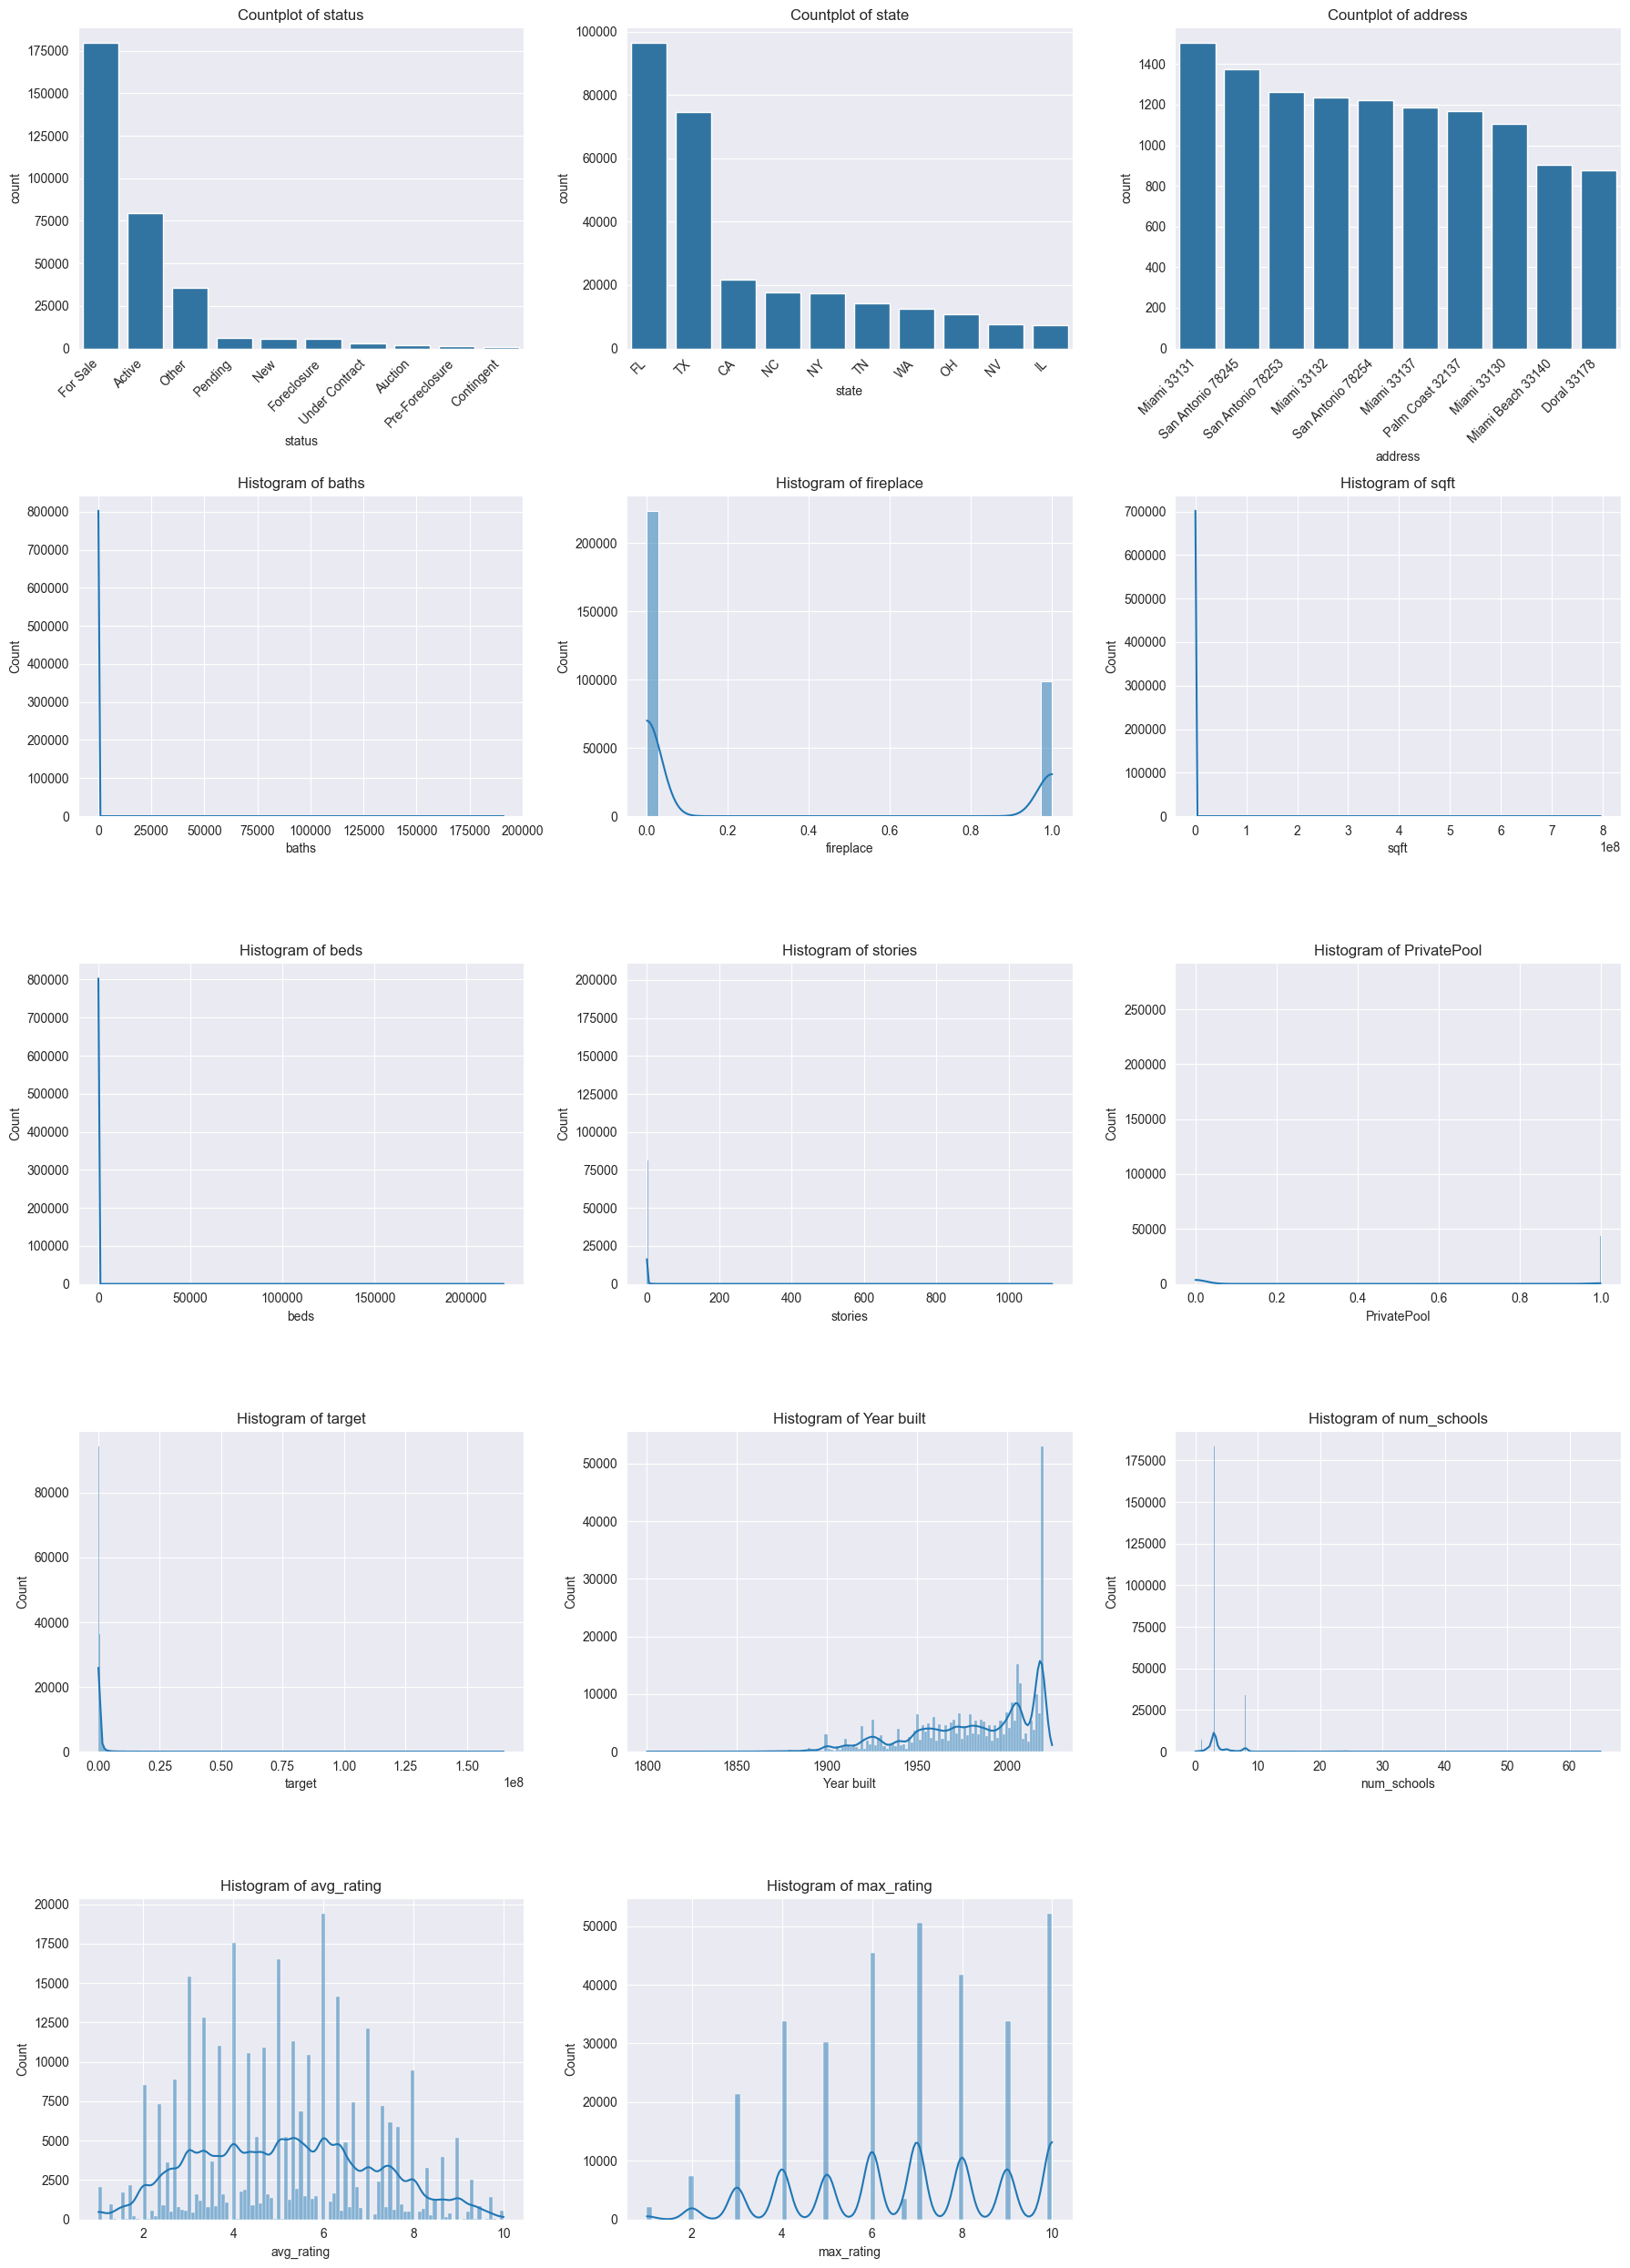

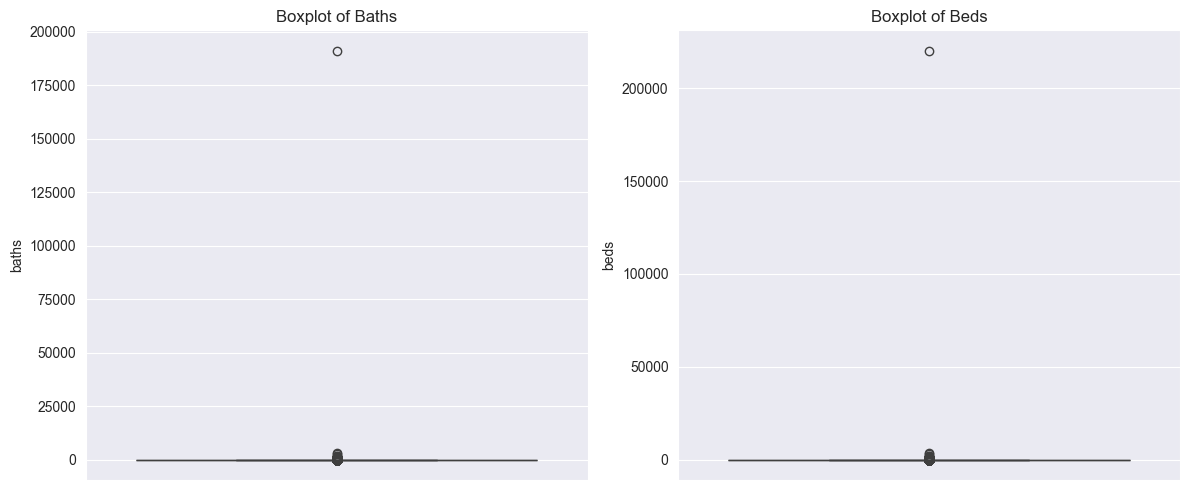

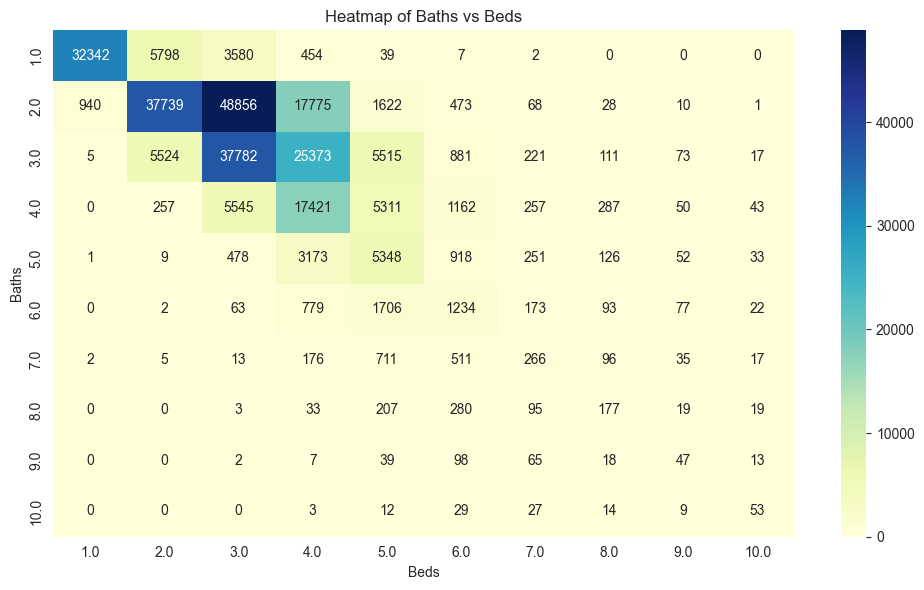

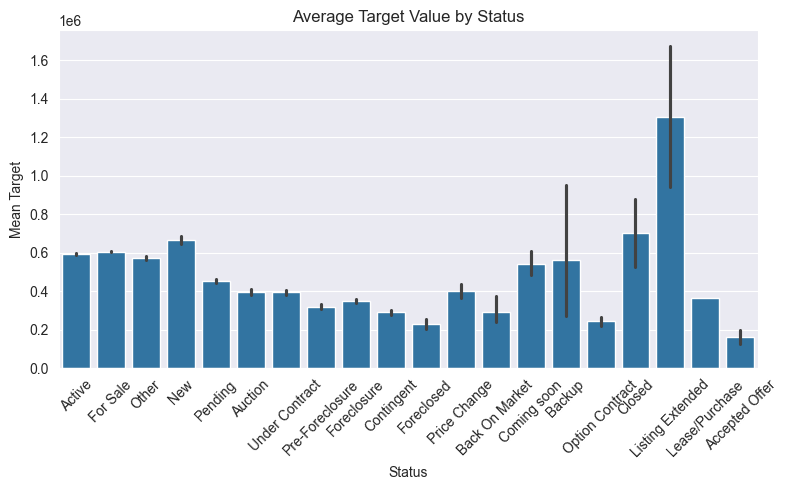

In [8]:
# Separate numeric and categorical columns (exclude bool) before removing outliers

numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = dataset.select_dtypes(include='object').columns

# Combine into one list (categorical + numeric)
columns_to_plot = list(categorical_cols) + list(numeric_cols)

# Define number of plots per row and total
cols_per_row = 3
n = len(columns_to_plot)
rows = (n + cols_per_row - 1) // cols_per_row

# Set up the subplot grid
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5 * rows))
axes = axes.flatten()

# Loop over all selected columns
for idx, col in enumerate(columns_to_plot):
    ax = axes[idx]

    if col in categorical_cols:
        sns.countplot(data=dataset, x=col, ax=ax, order=dataset[col].value_counts().index[:10])  # top 10
        ax.set_title(f'Countplot of {col}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    elif col in numeric_cols:
        sns.histplot(data=dataset, x=col, kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')

# Hide any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Baths&Beds boxplot
plt.figure(figsize=(12, 5))

# Boxplot for 'baths'
plt.subplot(1, 2, 1)
sns.boxplot(y=dataset['baths'])
plt.title('Boxplot of Baths')

# Boxplot for 'beds'
plt.subplot(1, 2, 2)
sns.boxplot(y=dataset['beds'])
plt.title('Boxplot of Beds')

plt.tight_layout()
plt.show()

# Removing of outliers
mask=((dataset['baths']<=10)&(dataset['baths']>=1)
      &(dataset['beds']<=10)&(dataset['beds']>=1)
      &(dataset['stories']<=3)
      &(dataset['sqft']<=10000)
      &(dataset['sqft']>=300)
      &(dataset['target']>=100000)&(dataset['target']<=10000000))
dataset=dataset[mask]

# Heatmap of baths and beds
heatmap_data = dataset.pivot_table(index='baths', columns='beds', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Baths vs Beds')
plt.xlabel('Beds')
plt.ylabel('Baths')
plt.tight_layout()
plt.show()

# Target and Status
plt.figure(figsize=(8, 5))
sns.barplot(data=dataset, x='status', y='target', estimator='mean')
plt.title('Average Target Value by Status')
plt.ylabel('Mean Target')
plt.xlabel('Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\3449802031.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\3449802031.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UserPC\AppData\Local\Temp\ipykernel_17752\3449802031.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


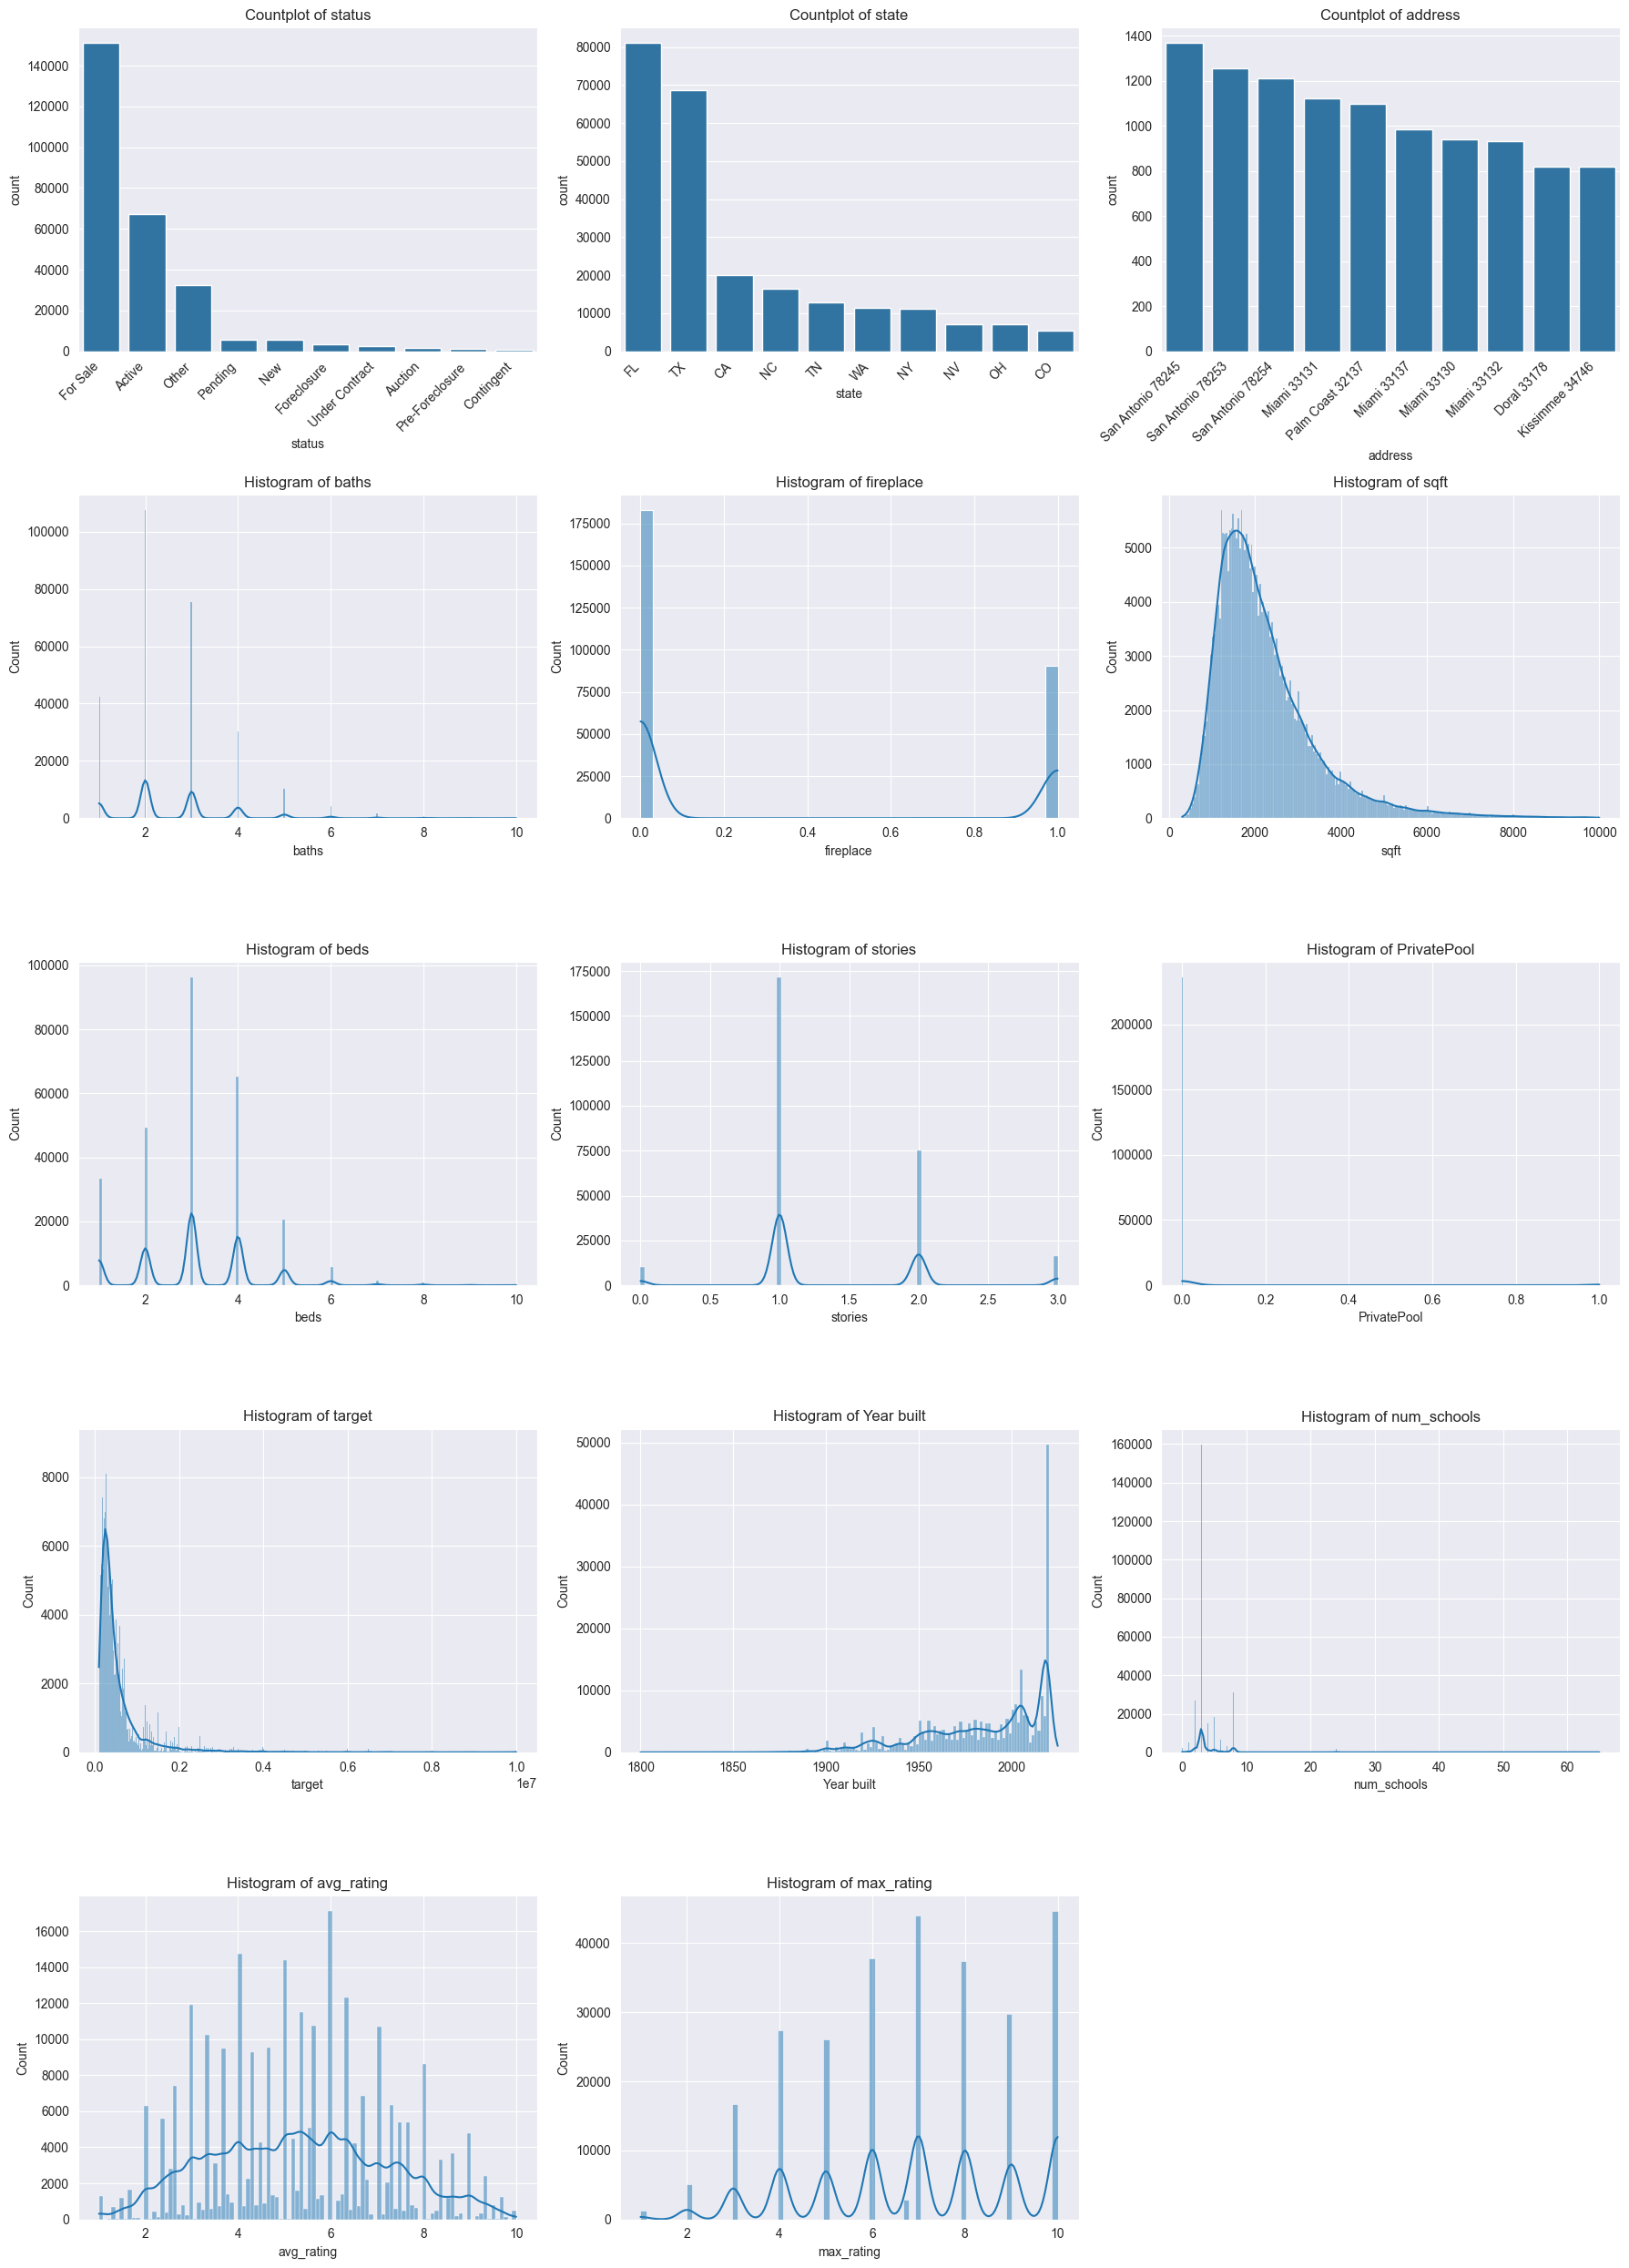

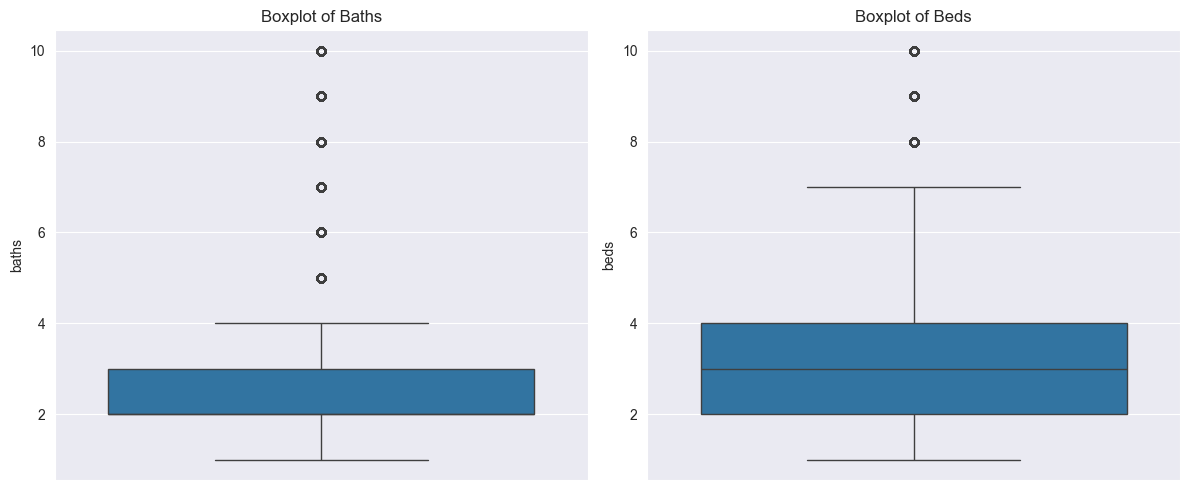

In [9]:
dataset=dataset[dataset['status']!='Rent']

# Separate numeric and categorical columns (exclude bool) after removing outliers

numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = dataset.select_dtypes(include='object').columns

# Combine into one list (categorical + numeric)
columns_to_plot = list(categorical_cols) + list(numeric_cols)

# Define number of plots per row and total
cols_per_row = 3
n = len(columns_to_plot)
rows = (n + cols_per_row - 1) // cols_per_row

# Set up the subplot grid
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 5 * rows))
axes = axes.flatten()

# Loop over all selected columns
for idx, col in enumerate(columns_to_plot):
    ax = axes[idx]

    if col in categorical_cols:
        sns.countplot(data=dataset, x=col, ax=ax, order=dataset[col].value_counts().index[:10])  # top 10
        ax.set_title(f'Countplot of {col}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    elif col in numeric_cols:
        sns.histplot(data=dataset, x=col, kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')

# Hide any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Baths&Beds boxplot after dropping outliers
plt.figure(figsize=(12, 5))

# Boxplot for 'baths'
plt.subplot(1, 2, 1)
sns.boxplot(y=dataset['baths'])
plt.title('Boxplot of Baths')

# Boxplot for 'beds'
plt.subplot(1, 2, 2)
sns.boxplot(y=dataset['beds'])
plt.title('Boxplot of Beds')

plt.tight_layout()
plt.show()

count   : 273,208.00
mean    : 258.05
std     : 248.41
min     : 10.02
25%     : 128.97
50%     : 179.40
75%     : 289.53
max     : 16,354.17


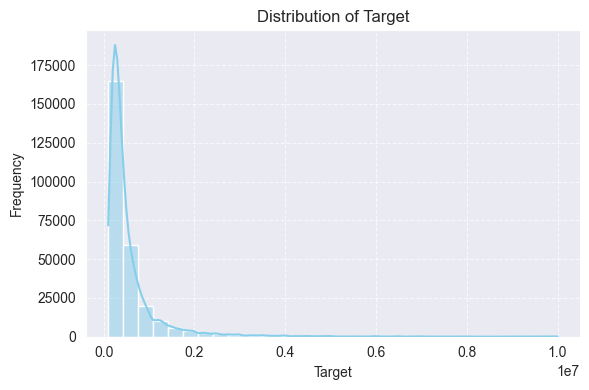

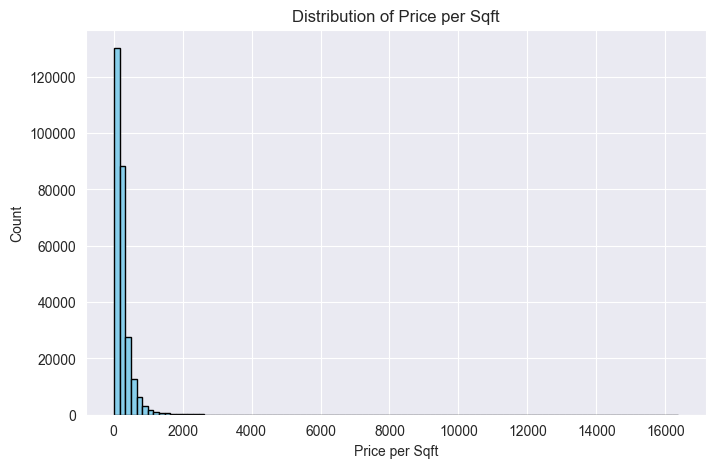

,target,beds,baths,sqft,price/sqft
0,100000,5.0,4.0,9983,10.017029
1,115000,5.0,4.0,10000,11.500000
2,115000,5.0,4.0,10000,11.500000
3,110000,5.0,4.0,9385,11.720831
4,105000,4.0,4.0,8416,12.476236
...,...,...,...,...,...
273203,9999999,3.0,2.0,1504,6648.935505
273204,9999999,3.0,2.0,1504,6648.935505
273205,5999000,6.0,6.0,760,7893.421053
273206,4200000,4.0,7.0,479,8768.267223


In [10]:
# Statistical significance examination of price/sqft by states

dataset['price/sqft']=dataset['target']/dataset['sqft']
# Get description
desc = dataset['price/sqft'].describe()

# Format and print
for stat, value in desc.items():
    if value >= 1000 or value < 1:
        print(f"{stat:<8}: {value:,.2f}")
    else:
        print(f"{stat:<8}: {value:.2f}")

#
plt.figure(figsize=(6, 4))
sns.histplot(dataset['target'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Price/Sqft distribution
plt.figure(figsize=(8, 5))
plt.hist(dataset['price/sqft'].dropna(), bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Price per Sqft')
plt.xlabel('Price per Sqft')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#
(dataset[['target', 'beds', 'baths', 'sqft', 'price/sqft']]
 .sort_values(by='price/sqft', ascending=True).reset_index(drop=True))

# Statistical analysis of target by states and addresses

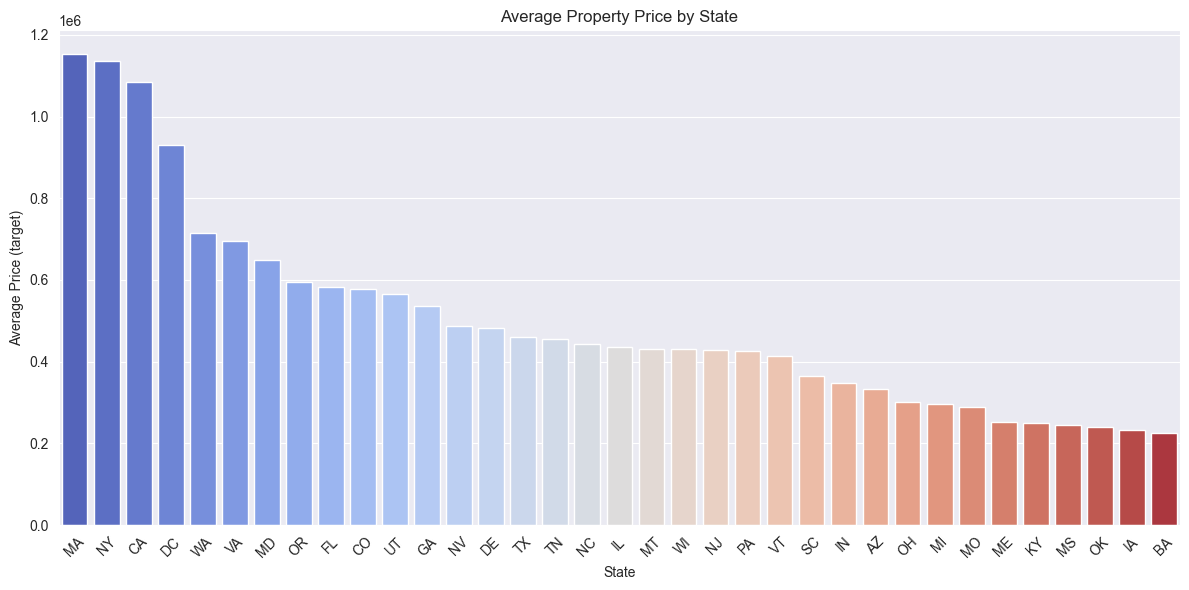

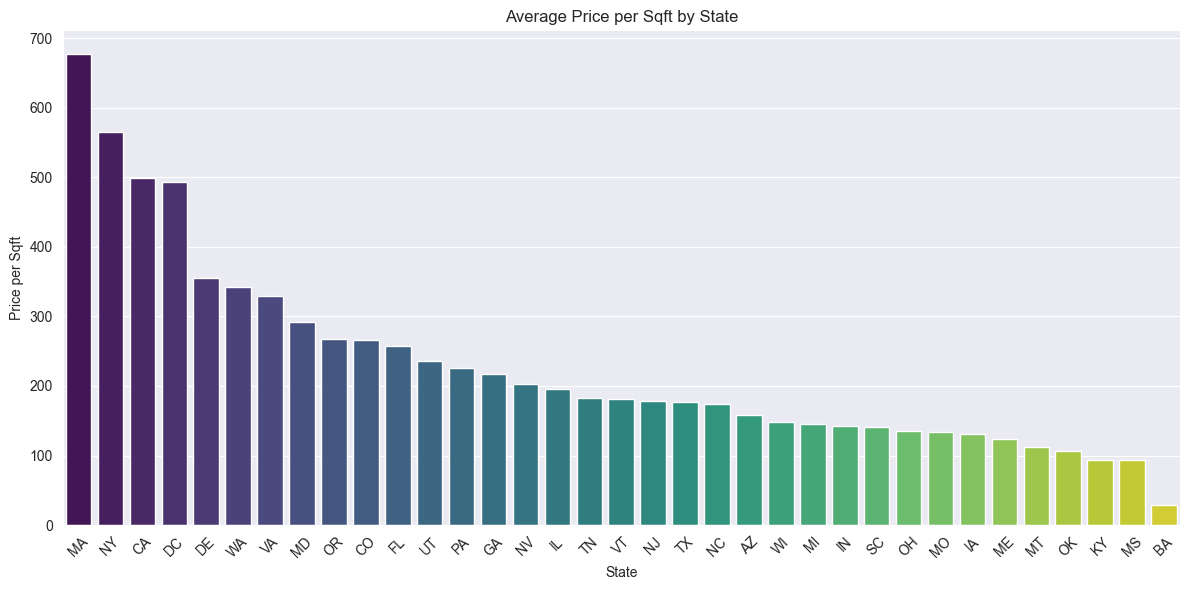

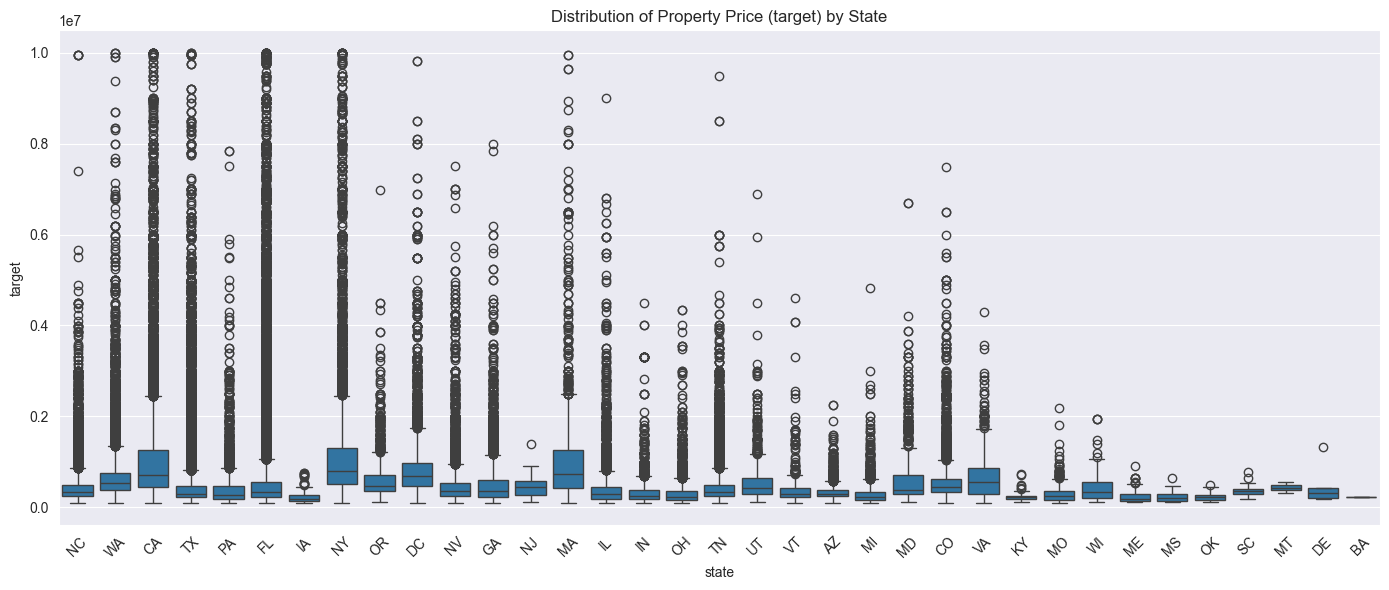

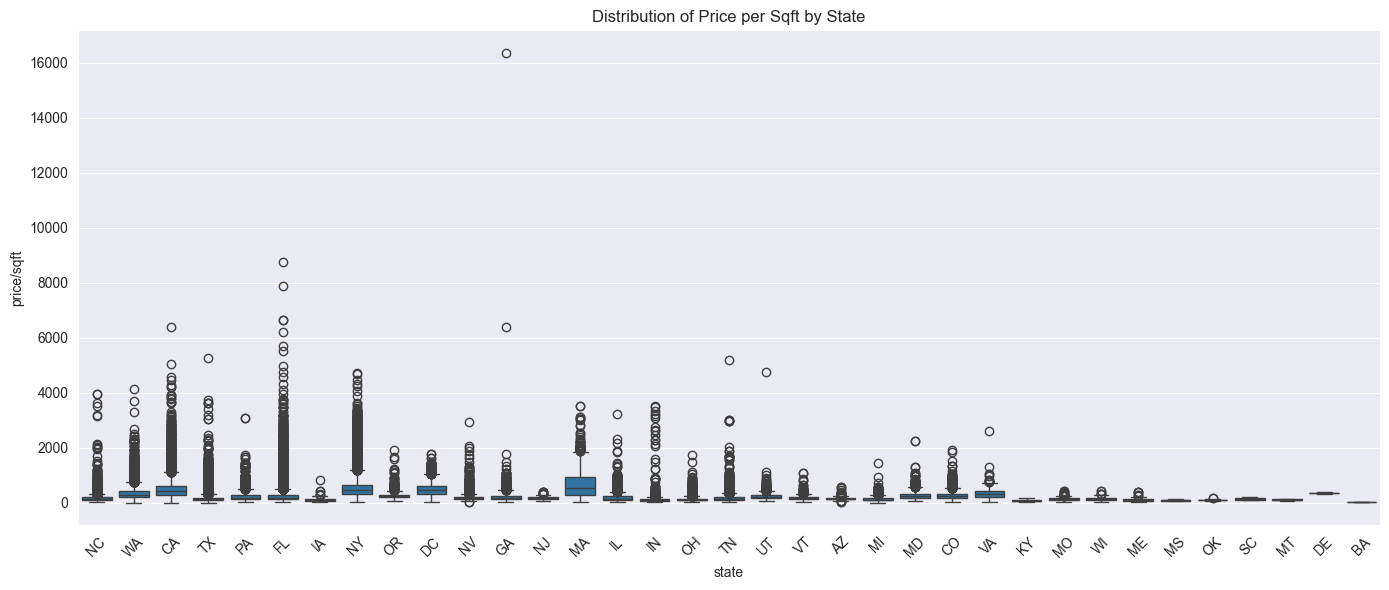

In [11]:
plt.figure(figsize=(12, 6))
avg_price = dataset.groupby('state')['target'].mean().sort_values(ascending=False)

sns.barplot(x=avg_price.index, y=avg_price.values, palette='coolwarm')
plt.title('Average Property Price by State')
plt.ylabel('Average Price (target)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#
plt.figure(figsize=(12, 6))
avg_ppsqft = dataset.groupby('state')['price/sqft'].mean().sort_values(ascending=False)

sns.barplot(x=avg_ppsqft.index, y=avg_ppsqft.values, palette='viridis')
plt.title('Average Price per Sqft by State')
plt.ylabel('Price per Sqft')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#
plt.figure(figsize=(14, 6))
sns.boxplot(x='state', y='target', data=dataset)
plt.title('Distribution of Property Price (target) by State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#
plt.figure(figsize=(14, 6))
sns.boxplot(x='state', y='price/sqft', data=dataset)
plt.title('Distribution of Price per Sqft by State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Statistical significance examination of prices by states

In [12]:
# Chi square
import pandas as pd
from scipy.stats import chi2_contingency


chi_set=dataset.copy()
# Create price range bins (quartiles or custom)
chi_set['price_range'] = pd.qcut(chi_set['target'], q=4, labels=['Low', 'Mid-low', 'Mid-high', 'High'])

# Create contingency table
contingency = pd.crosstab(chi_set['state'], chi_set['price_range'])

# (Optional) Drop states with very few listings to avoid sparse data
contingency = contingency[contingency.sum(axis=1) >= 30]

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.5f}")

# Chi-Square Statistic: 48948.35
# Degrees of Freedom: 84
# P-value: 0.00000
# Conclusion: test shows that price and states have significant relationship
#
from scipy.stats import f_oneway

# Drop rows with missing values
data_cleaned = dataset[['state', 'target', 'price/sqft']].dropna()

# Group by state
groups_target = [group['target'].values for _, group in data_cleaned.groupby('state')]
groups_price_per_sqft = [group['price/sqft'].values for _, group in data_cleaned.groupby('state')]

# ANOVA test for 'target'
anova_target = f_oneway(*groups_target)

# ANOVA test for 'price/sqft'
anova_price_sqft = f_oneway(*groups_price_per_sqft)

print("ANOVA on 'target':")
print(f"F-statistic: {anova_target.statistic:.2f}, P-value: {anova_target.pvalue:.5f}")

print("\nANOVA on 'price/sqft':")
print(f"F-statistic: {anova_price_sqft.statistic:.2f}, P-value: {anova_price_sqft.pvalue:.5f}")
# ANOVA on 'target':
# F-statistic: 651.52, P-value: 0.00000
# ANOVA on 'price/sqft':
# F-statistic: 2209.60, P-value: 0.00000
# # Conclusion: test shows that price/sqft and states have significant relationship

Chi-Square Statistic: 48948.35
Degrees of Freedom: 84
P-value: 0.00000
ANOVA on 'target':
F-statistic: 651.52, P-value: 0.00000

ANOVA on 'price/sqft':
F-statistic: 2209.60, P-value: 0.00000


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273208 entries, 0 to 321917
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          273208 non-null  object 
 1   baths           273208 non-null  float64
 2   fireplace       273208 non-null  int64  
 3   sqft            273208 non-null  int64  
 4   beds            273208 non-null  float64
 5   state           273208 non-null  object 
 6   stories         273208 non-null  float64
 7   PrivatePool     273208 non-null  int64  
 8   target          273208 non-null  int64  
 9   address         273208 non-null  object 
 10  Year built      273208 non-null  float64
 11  has_preschool   273208 non-null  bool   
 12  has_elementary  273208 non-null  bool   
 13  has_middle      273208 non-null  bool   
 14  has_high        273208 non-null  bool   
 15  num_schools     273208 non-null  int64  
 16  avg_rating      273208 non-null  float64
 17  max_rating     

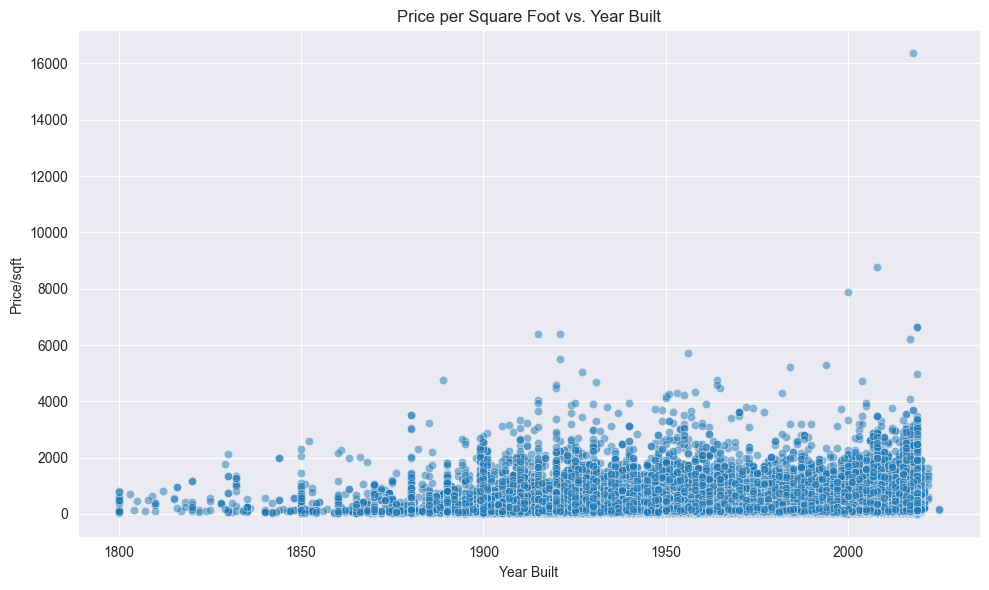

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='Year built', y='price/sqft', alpha=0.5)
plt.title('Price per Square Foot vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Price/sqft')
plt.tight_layout()
plt.show()

In [15]:
dataset['price/sqft'].max()

np.float64(16354.166666666666)

In [16]:
# Getting rid of outliers again
mask=(dataset['price/sqft']<=4000)&(dataset['Year built']>1900)
dataset=dataset[mask]

In [17]:
# Split data before pre-processing
# =================================================================================================================


data=dataset.drop('price/sqft', axis=1)
X=data.drop('target', axis=1)
y=data['target']

# ==============================================================================================================
# Feature Engineering
# ================================================================================================================
print(X['status'].nunique())
print(X['state'].nunique())
print(X['address'].nunique())
# Column transformation (step 1 in pipeline, status encoding)
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelBinarizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression  # example model
from sklearn.ensemble import RandomForestClassifier  # or any other model


# --- Step 1: Define transformations ---

# Log transform sqft (and handle zero or negative values)
def safe_log_transform(x):
    return np.log1p(x)


log_transformer = FunctionTransformer(safe_log_transform, validate=False)


# Custom wrapper to apply FeatureHasher on string columns
class FeatureHasherEncoder:
    def __init__(self, n_features=8, input_type='string'):
        self.n_features = n_features
        self.input_type = input_type
        self.hasher = FeatureHasher(n_features=self.n_features, input_type=self.input_type)

    def fit(self, X, y=None):
        return self  # stateless

    def transform(self, X):
        return self.hasher.transform(X.values.reshape(-1, 1)).toarray()

    def fit_transform(self, X, y=None):
        return self.transform(X)


# --- Step 2: Define column-specific transformations ---

preprocessor = ColumnTransformer(transformers=[

    # Binary encode 'status'
    ('status_bin', OneHotEncoder(drop='if_binary', dtype=np.int8, handle_unknown='ignore'), ['status']),

    # Hash encode 'state' (16 components)
    ('state_hash', FunctionTransformer(FeatureHasherEncoder(n_features=16).fit_transform, validate=False), 'state'),

    # Hash encode 'address' (128 components)
    ('addr_hash', FunctionTransformer(FeatureHasherEncoder(n_features=128).fit_transform, validate=False), 'address'),

    # Log transform 'sqft'
    ('sqft_log', log_transformer, ['sqft']),

    # Scale 'sqft' and 'Year built'
    ('scaler', StandardScaler(), ['sqft', 'Year built'])

], remainder='passthrough')  # keep other numeric/boolean features



20
34
5604


# Creating Pipelines for smooth modeling

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Example base preprocessing pipeline (already defined)


# 1. Linear Regression
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

# 2. Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge(alpha=1.0))
])

# 3. Lasso Regression
lasso_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Lasso(alpha=0.1, max_iter=10000))  # increased from 1000 to 10000
])

# 4. Random Forest
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 5. Gradient Boosting
gbr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# 6. Decision Tree
dt_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=10, random_state=42))
])

# 7. Support Vector Regressor
svr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVR(kernel='rbf', C=1.0, epsilon=0.1))
])

# 8. XGBoost
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# 9. LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Testing/ Cross Validating models

In [19]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Define the pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Perform cross-validation
scores = cross_val_score(
    ridge_pipeline,
    X, y,
    cv=5,  # 5-fold CV
    scoring='neg_root_mean_squared_error'  # or 'neg_mean_squared_error', 'r2', etc.
)

# Since scores are negative RMSE (as per sklearn convention), take absolute value
print("Cross-validated RMSE scores:", -scores)
print("Mean RMSE:", -scores.mean())

# Cross-validated RMSE scores: [569660.14412315 569471.9561931  564643.40322387 547316.55716432 563248.7979195 ]
# Mean RMSE: 562868.1717247865

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated RMSE scores: [569660.14412315 569471.9561931  564643.40322387 547316.55716432
 563248.7979195 ]
Mean RMSE: 562868.1717247865


In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Perform 5-fold cross-validation with RMSE
lr_scores = cross_val_score(
    lr_pipeline,
    X, y,
    cv=5,
    scoring='neg_root_mean_squared_error'  # sklearn returns negative RMSE
)

# Report results
print("Cross-validated RMSE scores:", -lr_scores)
print("Mean RMSE:", -lr_scores.mean())

# Cross-validated RMSE scores: [569660.31896035 569477.07429595 564642.58649092 547316.56849836
#  563249.20005314]
# Mean RMSE: 562869.1496597467

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated RMSE scores: [569660.31896035 569477.07429595 564642.58649092 547316.56849836
 563249.20005314]
Mean RMSE: 562869.1496597467


In [21]:
# Cross-validate the Random Forest pipeline
rf_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')

# Display results
print("Random Forest CV R² scores:", rf_scores)
print("Mean R² score:", np.mean(rf_scores))

# Random Forest CV R² scores: [0.76336235 0.76181819 0.77242073 0.76823923 0.77859057]
# Mean R² score: 0.768886213548528

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest CV R² scores: [0.76336235 0.76181819 0.77242073 0.76823923 0.77859057]
Mean R² score: 0.768886213548528


In [22]:
# 5-fold cross-validated RMSE (note the negative scoring)
neg_rmse_scores = cross_val_score(
    rf_pipeline, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Convert negative RMSE to positive
rmse_scores = -neg_rmse_scores

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

# Cross-validated RMSE scores: [378799.74685192 376508.92536332 367125.07563841 360773.2119712
#  359874.27830161]
# Mean RMSE: 368616.24762529205

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated RMSE scores: [378799.74685192 376508.92536332 367125.07563841 360773.2119712
 359874.27830161]
Mean RMSE: 368616.24762529205


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import numpy as np

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Perform cross-validation
mape_scores = -cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=5,
    scoring=mape_scorer
)

# Convert to percentage
mape_scores_percent = mape_scores * 100

# Output
print("Cross-validated MAPE scores (%):", mape_scores_percent)
print("Mean MAPE (%):", np.mean(mape_scores_percent))

# Cross-validated MAPE scores (%): [23.84524436 24.33274998 24.23930011 24.30729012 24.20943424]
# Mean MAPE (%): 24.186803760646065

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated MAPE scores (%): [23.84524436 24.33274998 24.23930011 24.30729012 24.20943424]
Mean MAPE (%): 24.186803760646065


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Ваш pipeline
gbr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# MAPE scorer (если sklearn < 0.24 или нужно вручную в процентах)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Кросс-валидация
mape_scores = cross_val_score(gbr_pipeline, X, y, cv=5, scoring=mape_scorer)

# Печатаем в удобном виде (умножаем на -100 для процента)
print("Cross-validated MAPE scores (%):", -mape_scores * 100)
print("Mean MAPE: {:.2f}%".format(-mape_scores.mean() * 100))

# Cross-validated MAPE scores (%): [44.12074072 44.14417209 44.34895857 44.24058672 44.22830348]
# Mean MAPE: 44.22%

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated MAPE scores (%): [44.12074072 44.14417209 44.34895857 44.24058672 44.22830348]
Mean MAPE: 44.22%


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Pipeline
dt_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=10, random_state=42))
])

# MAPE scorer (в долях, так что потом умножаем на 100)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Кросс-валидация
mape_scores = cross_val_score(dt_pipeline, X, y, cv=5, scoring=mape_scorer)

# Результаты в процентах
print("Cross-validated MAPE scores (%):", -mape_scores * 100)
print("Mean MAPE: {:.2f}%".format(-mape_scores.mean() * 100))

# Cross-validated MAPE scores (%): [45.6048005  46.06982803 46.33029301 46.32706034 45.99709864]
# Mean MAPE: 46.07%

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated MAPE scores (%): [45.6048005  46.06982803 46.33029301 46.32706034 45.99709864]
Mean MAPE: 46.07%


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from lightgbm import LGBMRegressor

# Pipeline
lgbm_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# MAPE scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Кросс-валидация
mape_scores = cross_val_score(lgbm_pipeline, X, y, cv=5, scoring=mape_scorer)

# Результаты
print("Cross-validated MAPE scores (%):", -mape_scores * 100)
print("Mean MAPE: {:.2f}%".format(-mape_scores.mean() * 100))

# Cross-validated MAPE scores (%): [37.48410213 37.78004497 37.62597199 37.71755313 37.91333233]
# Mean MAPE: 37.70%

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 215440, number of used features: 173
[LightGBM] [Info] Start training from score 580594.985523


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 215441, number of used features: 173
[LightGBM] [Info] Start training from score 580883.577295


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 215441, number of used features: 173
[LightGBM] [Info] Start training from score 581132.932631


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 215441, number of used features: 173
[LightGBM] [Info] Start training from score 582999.811289


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 215441, number of used features: 172
[LightGBM] [Info] Start training from score 581582.382722


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated MAPE scores (%): [37.48410213 37.78004497 37.62597199 37.71755313 37.91333233]
Mean MAPE: 37.70%


G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from xgboost import XGBRegressor

# Pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0))
])

# MAPE scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Кросс-валидация
mape_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring=mape_scorer)

# Результаты
print("Cross-validated MAPE scores (%):", -mape_scores * 100)
print("Mean MAPE: {:.2f}%".format(-mape_scores.mean() * 100))

# Cross-validated MAPE scores (%): [37.63691783 37.79096007 38.02796602 37.69099712 37.95770705]
# Mean MAPE: 37.82%

G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
G:\My Drive\PythonProject\Final Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validated MAPE scores (%): [37.63691783 37.79096007 38.02796602 37.69099712 37.95770705]
Mean MAPE: 37.82%


### Conclusion
### The best prediction model for the dataset is proven to be rf_pipeline (Random Forest) with default hyperparameters